In [1]:
%matplotlib inline
from tqdm import tqdm
import os, pathlib
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.model_selection import KFold
from scipy.stats import wilcoxon, linregress
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import ccaTools as cca
        from tools import rasterTools as rt
        from tools import corrTools as ct
        from tools import decodeTools as decode
        from tools import lstm
        import params
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

FIGPATH = params.figPath / 'fig2'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


### Get data

In [2]:
full_list_MCx_monkey, allDFs_MCx_monkey = dt.get_full_monkey_data(GoodDataList_CO)
allDFs_M1_mouse, _ = dt.get_full_mouse_data()
raster_example_df = dt.get_example_monkey_data(epoch = monkey_defs.exec_epoch)

### Fig 2A: Raster panel

Executed: `plot_fr_raster` in 0.1s
Executed: `plot_fr_raster` in 0.1s
Executed: `plot_pos_ex` in 0.1s
Executed: `plot_pos_ex` in 0.1s


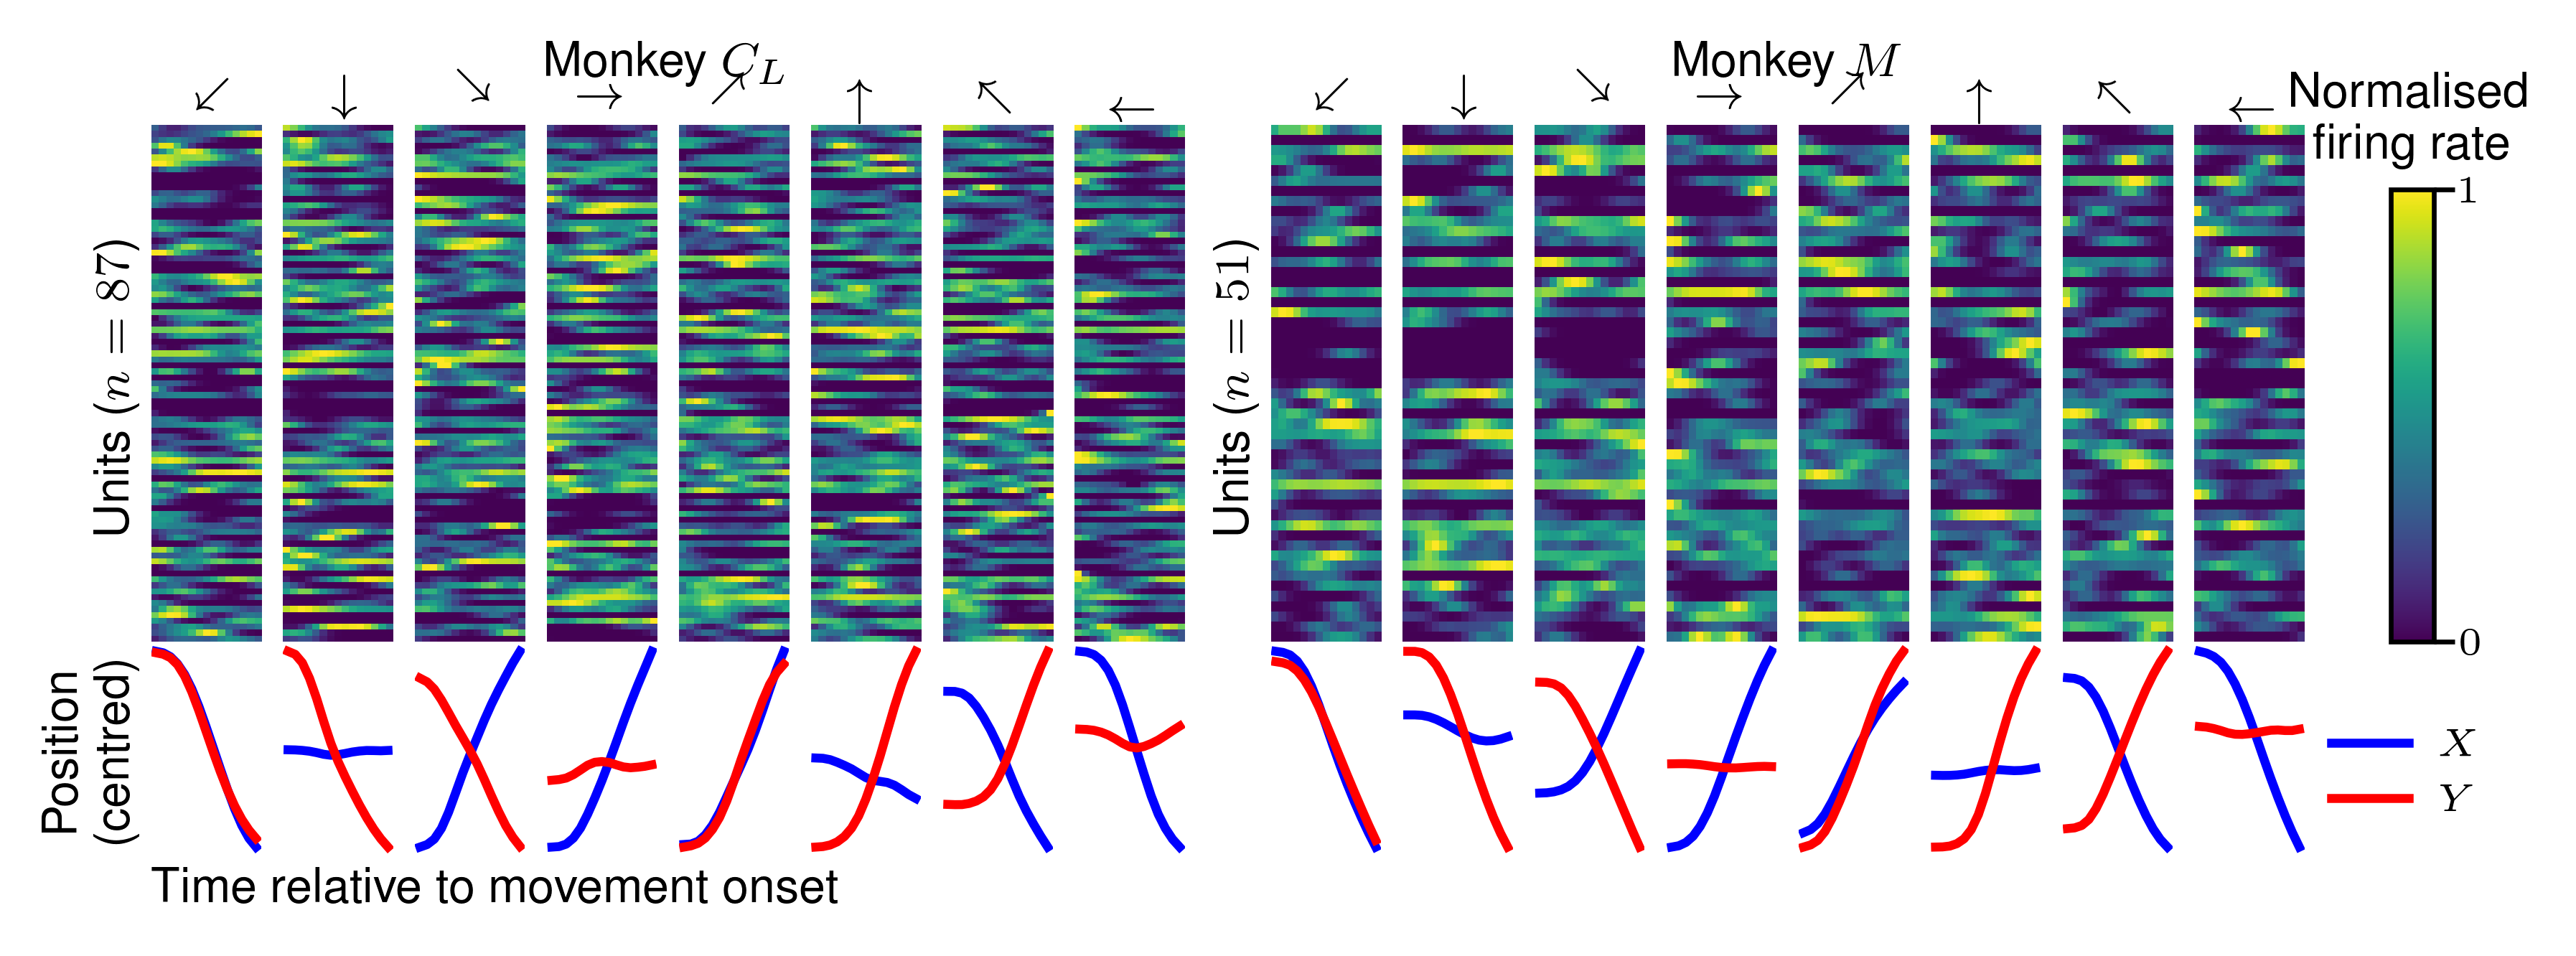

In [3]:
figsize=params.LargeFig
fig=plt.figure(figsize=figsize)

gs2_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                    left=params.panels.schmatic[0],
                                    bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1],
                                    width=params.panels.raster[0], 
                                    height=params.panels.raster[1])
gs2_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                    right=figsize[0],
                                    top=figsize[1],
                                    width=params.panels.raster[0], 
                                    height=params.panels.raster[1])

gs2_3 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                    left=params.panels.schmatic[0],
                                    bottom=figsize[1]-params.panels.schmatic[1],
                                    width=params.panels.raster[0], 
                                    height=params.panels.velocity[1])
gs2_4 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                    right=figsize[0],
                                    top=figsize[1]-params.panels.raster[1],
                                    width=params.panels.raster[0], 
                                    height=params.panels.velocity[1])

axes2_1 = rt.plot_fr_raster(raster_example_df[0], gs2_1, fig, range(monkey_defs.n_targets))
axes2_2 = rt.plot_fr_raster(raster_example_df[1], gs2_2, fig, range(monkey_defs.n_targets))
utility.phantom_axes(fig.add_subplot(gs2_1[:])).set_title('Monkey $C_L$', pad=8)
utility.phantom_axes(fig.add_subplot(gs2_2[:])).set_title('Monkey $M$', pad=8)

axes2_3 = rt.plot_pos_ex(raster_example_df[0], gs2_3, fig, range(monkey_defs.n_targets))
axes2_4 = rt.plot_pos_ex(raster_example_df[1], gs2_4, fig, range(monkey_defs.n_targets))

axes2_3[0].set_ylabel('Position\n(centred)')
axes2_3[0].set_xlabel('Time relative to movement onset',loc='left')
X_line = mlines.Line2D([], [], color='blue', label='$X$')
Y_line = mlines.Line2D([], [], color='red', label='$Y$')
axes2_4[-1].legend(handles=[X_line, Y_line], loc=(1.1,.1))
    
gs2_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                    height=params.panels.raster[1]-.15, 
                                    width=.1, 
                                    left=figsize[0]+.2, 
                                    bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1])
cax2 = fig.add_subplot(gs2_c[:])
fig.colorbar(cm.ScalarMappable(),cax=cax2, ticks=(0,1),drawedges=False)
cax2.set_title('Normalised\nfiring rate')

fig.savefig(FIGPATH / 'rasters.pdf', format='pdf', bbox_inches='tight')


### Fig 2C-E: 3D dynamics panel

In [4]:
@utility.report
def plot_monkey_pc_example(raster_example_df, gs):   
    fig=gs.figure
    
    colors = utility.get_colors(8)
    dfs=[]
    axes=[]
    for i,df in enumerate(raster_example_df):
        rates = np.concatenate(df['M1_rates'].values, axis=0)
        rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
        dfs.append(df_)
        ax = fig.add_subplot(gs[i], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(monkey_defs.n_targets):
            df__ = pyal.select_trials(df_, df_.target_id==tar)
            ex = pyal.get_sig_by_trial(df__,'_pca')
            ex = np.mean(ex, axis=2)[:,:3]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
    data1 = np.reshape(AllData[0,...], (-1,10))
    data2 = np.reshape(AllData[1,...], (-1,10))
    A,B,*_ = cca.canoncorr(data1,data2,fullReturn=True)
    coef_ = [A,B]
    for i,sessionData in enumerate(AllData):
        ax = fig.add_subplot(gs[i+3], projection='3d',fc='None')
        U, _, Vh = linalg.svd(coef_[i], full_matrices=False, compute_uv=True, overwrite_a=False, check_finite=False)
        axes.append(ax)
        for tar in range(8):
            ex = np.mean(sessionData[tar,...], axis=0)
            ex = ex @ U @ Vh
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    titles=[r'Monkey $C_L$ (\textit{unaligned})',r'Monkey $M$ (\textit{unaligned})',
            r'Monkey $C_L$ (\textit{aligned})',  r'Monkey $M$ (\textit{aligned})']
    labels = ['PC','PC','CC','CC']
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel(f'{labels[i]}1', labelpad=-15)
        ax.set_ylabel(f'{labels[i]}2', labelpad=-15)
        ax.set_zlabel(f'{labels[i]}3', labelpad=-15)
        ax.set_title(titles[i], y=.9, loc='center')
    
    #======== add the arrow
    
    ax = fig.add_subplot(gs[2], fc='None')
    ax = utility.phantom_axes(ax)
    ax.arrow(0,0,1,0,length_includes_head=True, width=.005, head_width=.015,head_length=.1, ec='k', fc='k')
    ax.set_ylim([-.1,.1])
    ax.set_xlim([-.5,1.1])
    ax.text(0.5,0.01,'CCA', ha='center', va='bottom')
    ax.text(0.5,-0.01,'(alignment)', ha='center', va='top')
    
    return axes

Executed: `plot_monkey_pc_example` in 0.7s


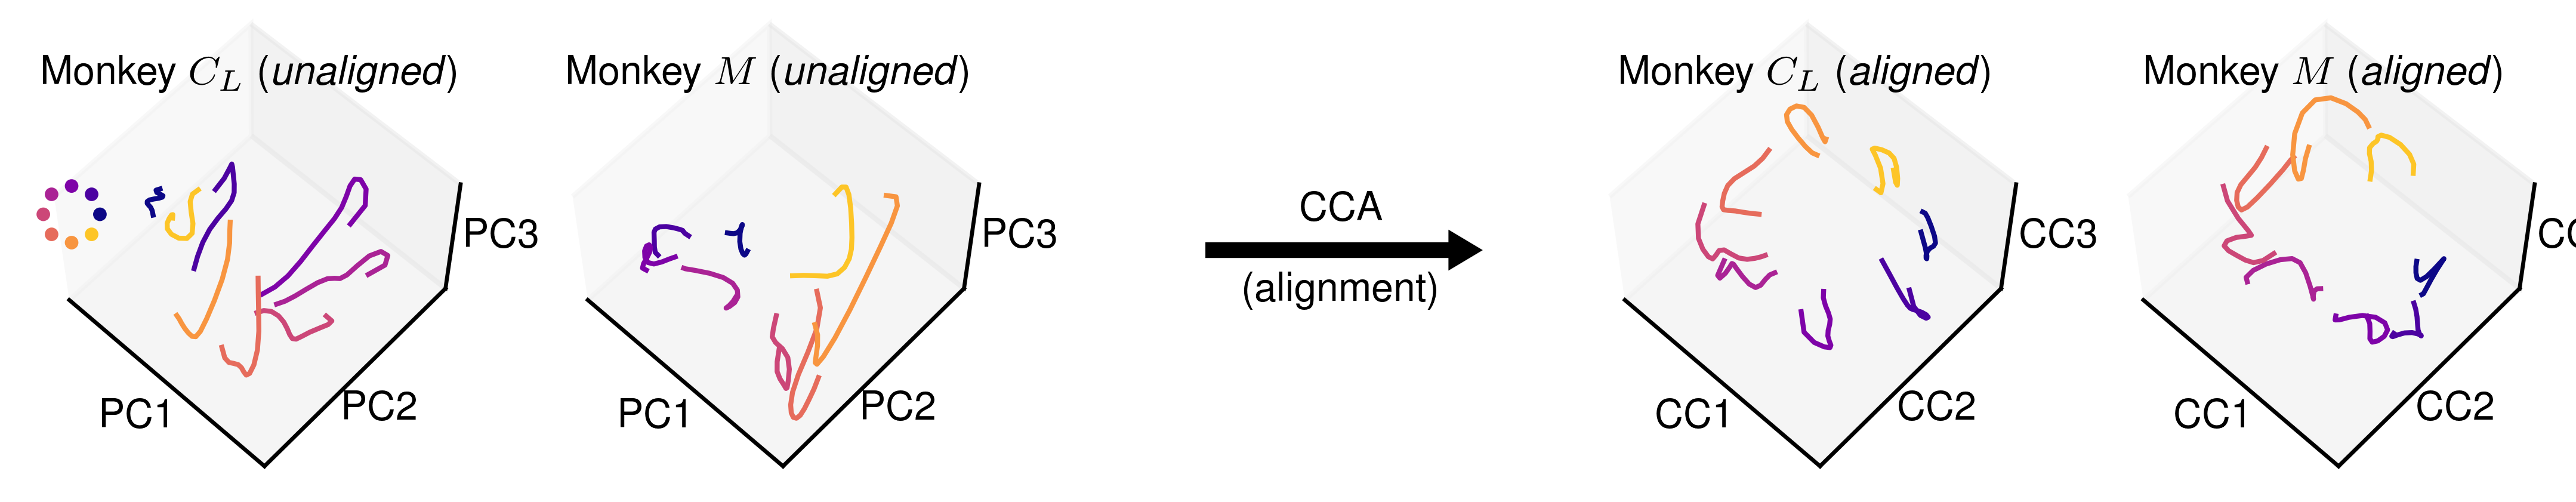

In [5]:
figsize=params.LargeFig
fig=plt.figure(figsize=figsize)
gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=5, left=0, 
                                bottom=figsize[1]-params.panels.schmatic[1]-params.panels.proj_3d_align[1]-.3,
                                width=params.panels.proj_3d_align[0], 
                                height=params.panels.proj_3d_align[1])

axes3 = plot_monkey_pc_example(raster_example_df, gs3)


gs3_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0,
                                bottom=(axes3[0].get_position().y0+axes3[0].get_position().y1)/2*figsize[1],
                                width=.2, height=0.2)
cax3 = fig.add_subplot(gs3_c[0],zorder=10)

utility.plot_targets(cax3,3)
cax3.set_xlim(np.array(cax3.get_xlim())*1.15)
cax3.set_ylim(np.array(cax3.get_ylim())*1.15)

fig.savefig(FIGPATH / '3d-dynamics-example.pdf', format='pdf', bbox_inches='tight')


### Fig 2F: CCA for monkey example session

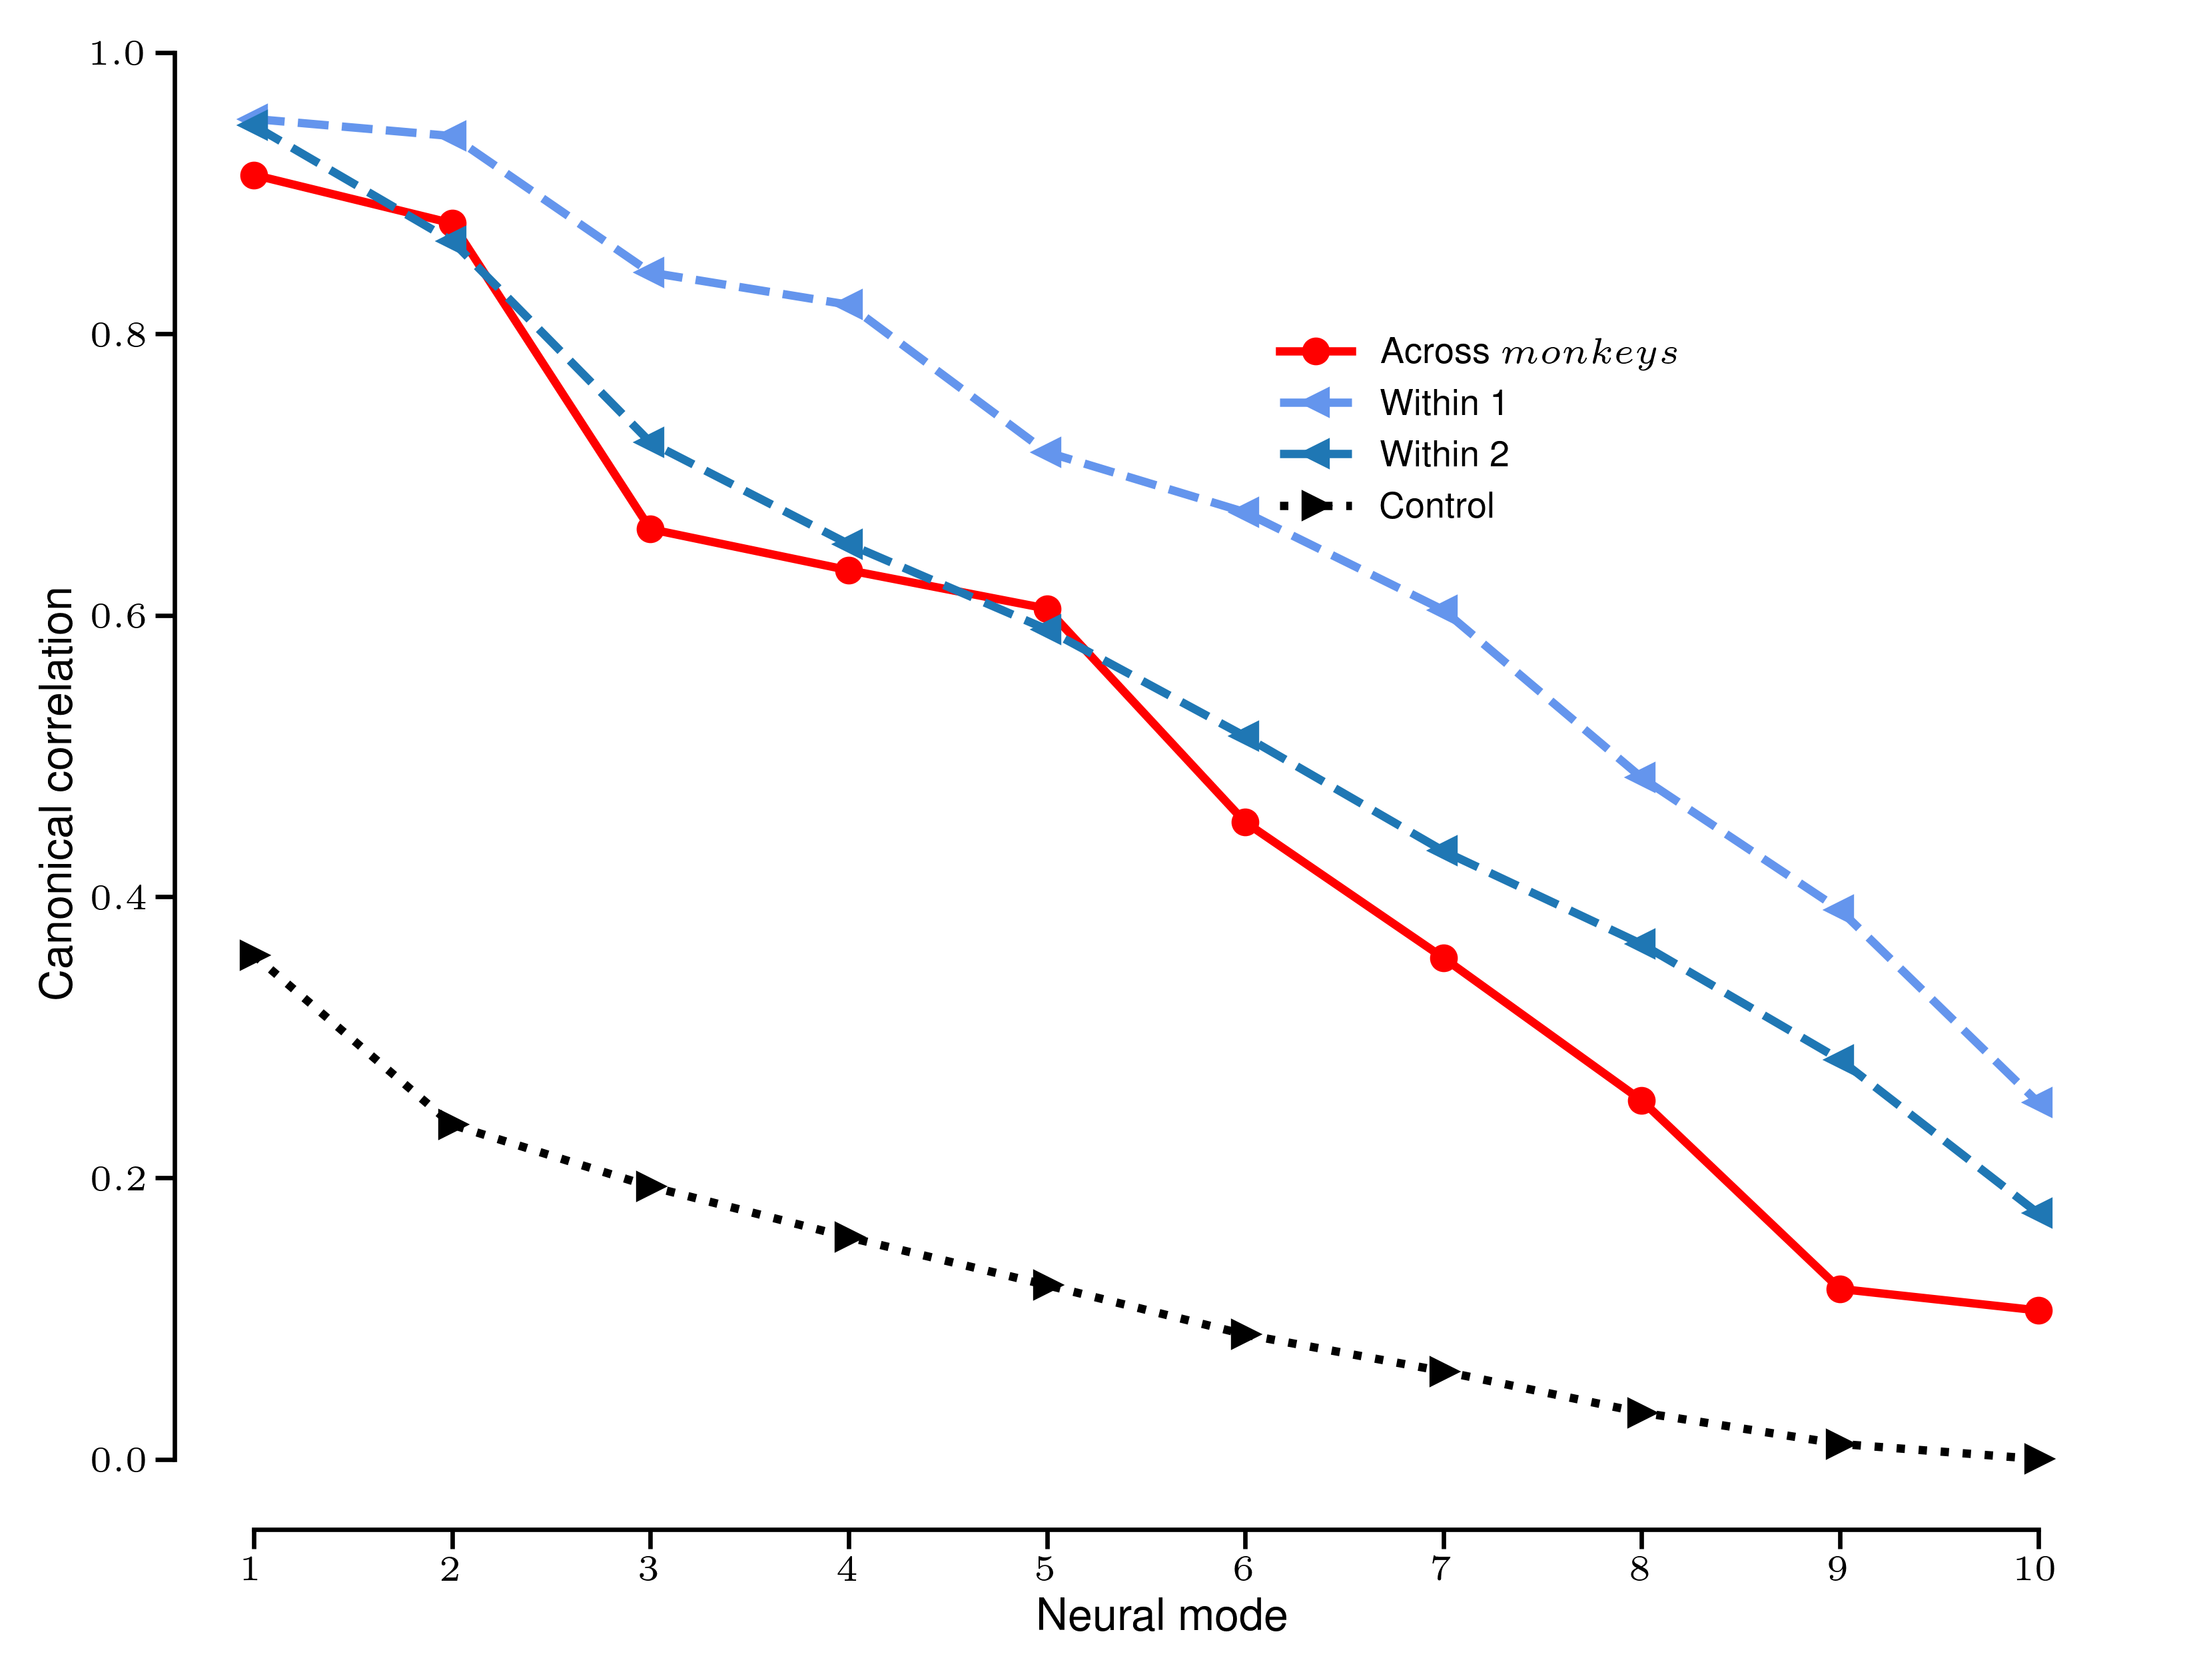

In [6]:
example_dfs = dt.get_example_monkey_data()

fig, ax = plt.subplots()
cca.plot_cca_for_ex(ax, example_dfs, 
                   monkey_defs.exec_epoch, 
                   monkey_defs.areas[2], 
                   monkey_defs.n_components, 
                   dataset='monkey')

fig.savefig(FIGPATH / 'monkey-cca-example.pdf', format='pdf', bbox_inches='tight')


### Fig 2G: monkey population CCA plot

/home/jcc319/multi_animal_alignment/tools/dataTools.py:129: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:129: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:129: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:129: UserWarning: Dropping the trials with the following 

Across vs within: WilcoxonResult(statistic=20.0, pvalue=5.52830372958812e-43)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=2.029467500049271e-22)
Executed: `plot_cca` in 180.0s


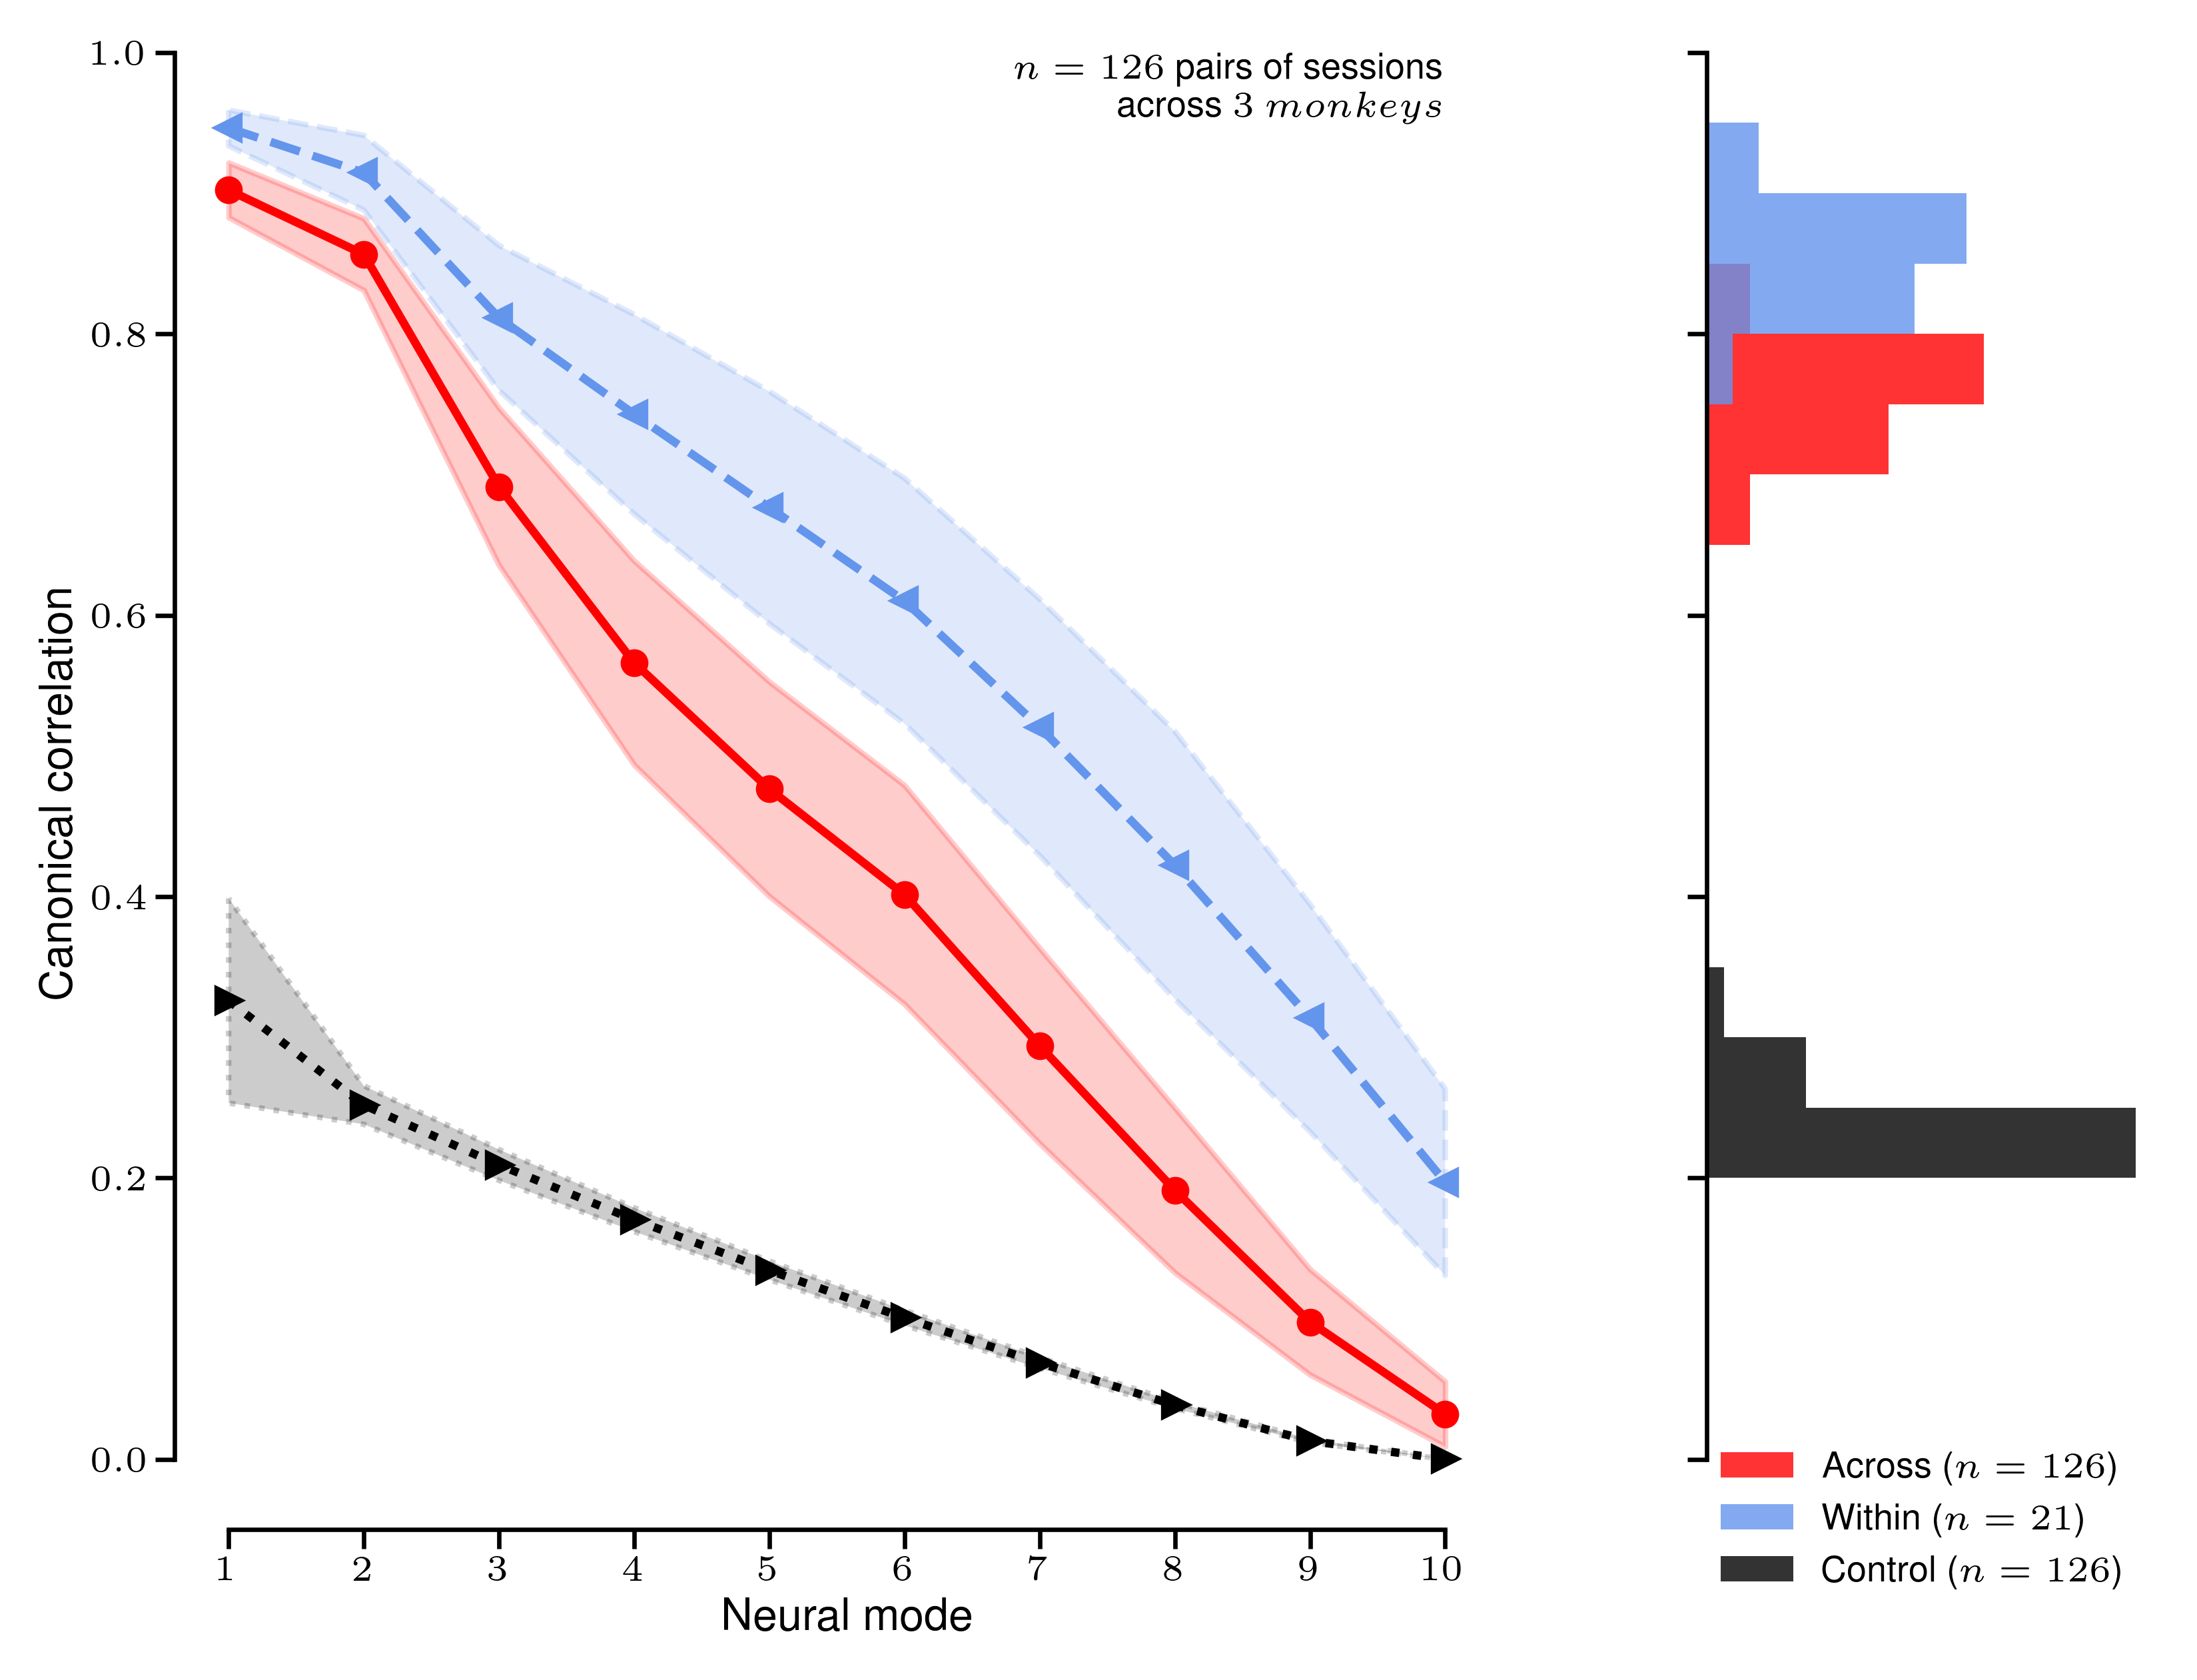

In [7]:
fig, axes = plt.subplots(ncols = 2, gridspec_kw={'width_ratios': [params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]]})

cca.plot_cca(axes[0], axes[1], allDFs_MCx_monkey, 
            monkey_defs.exec_epoch, 
            monkey_defs.areas[2], 
            monkey_defs.n_components, 
            dataset='monkey')
fig.savefig(FIGPATH / 'monkey-cca.pdf', format='pdf', bbox_inches='tight')


### Fig 2H: decoding for monkeys

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 10639.01it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 16278.02it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 16656.65it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 11618.57it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 11664.73it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 11807.02it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 11853.10it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 11933.39it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 12170.84it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 12235.09it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 15496.20it/s]

100%|████████████████████████████████████████| 21/21 [00:00<00:00, 15468.98it/s]

100%|███████████

Across vs within: WilcoxonResult(statistic=10536.0, pvalue=3.0889572566848096e-06)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=2.029467500049271e-22)


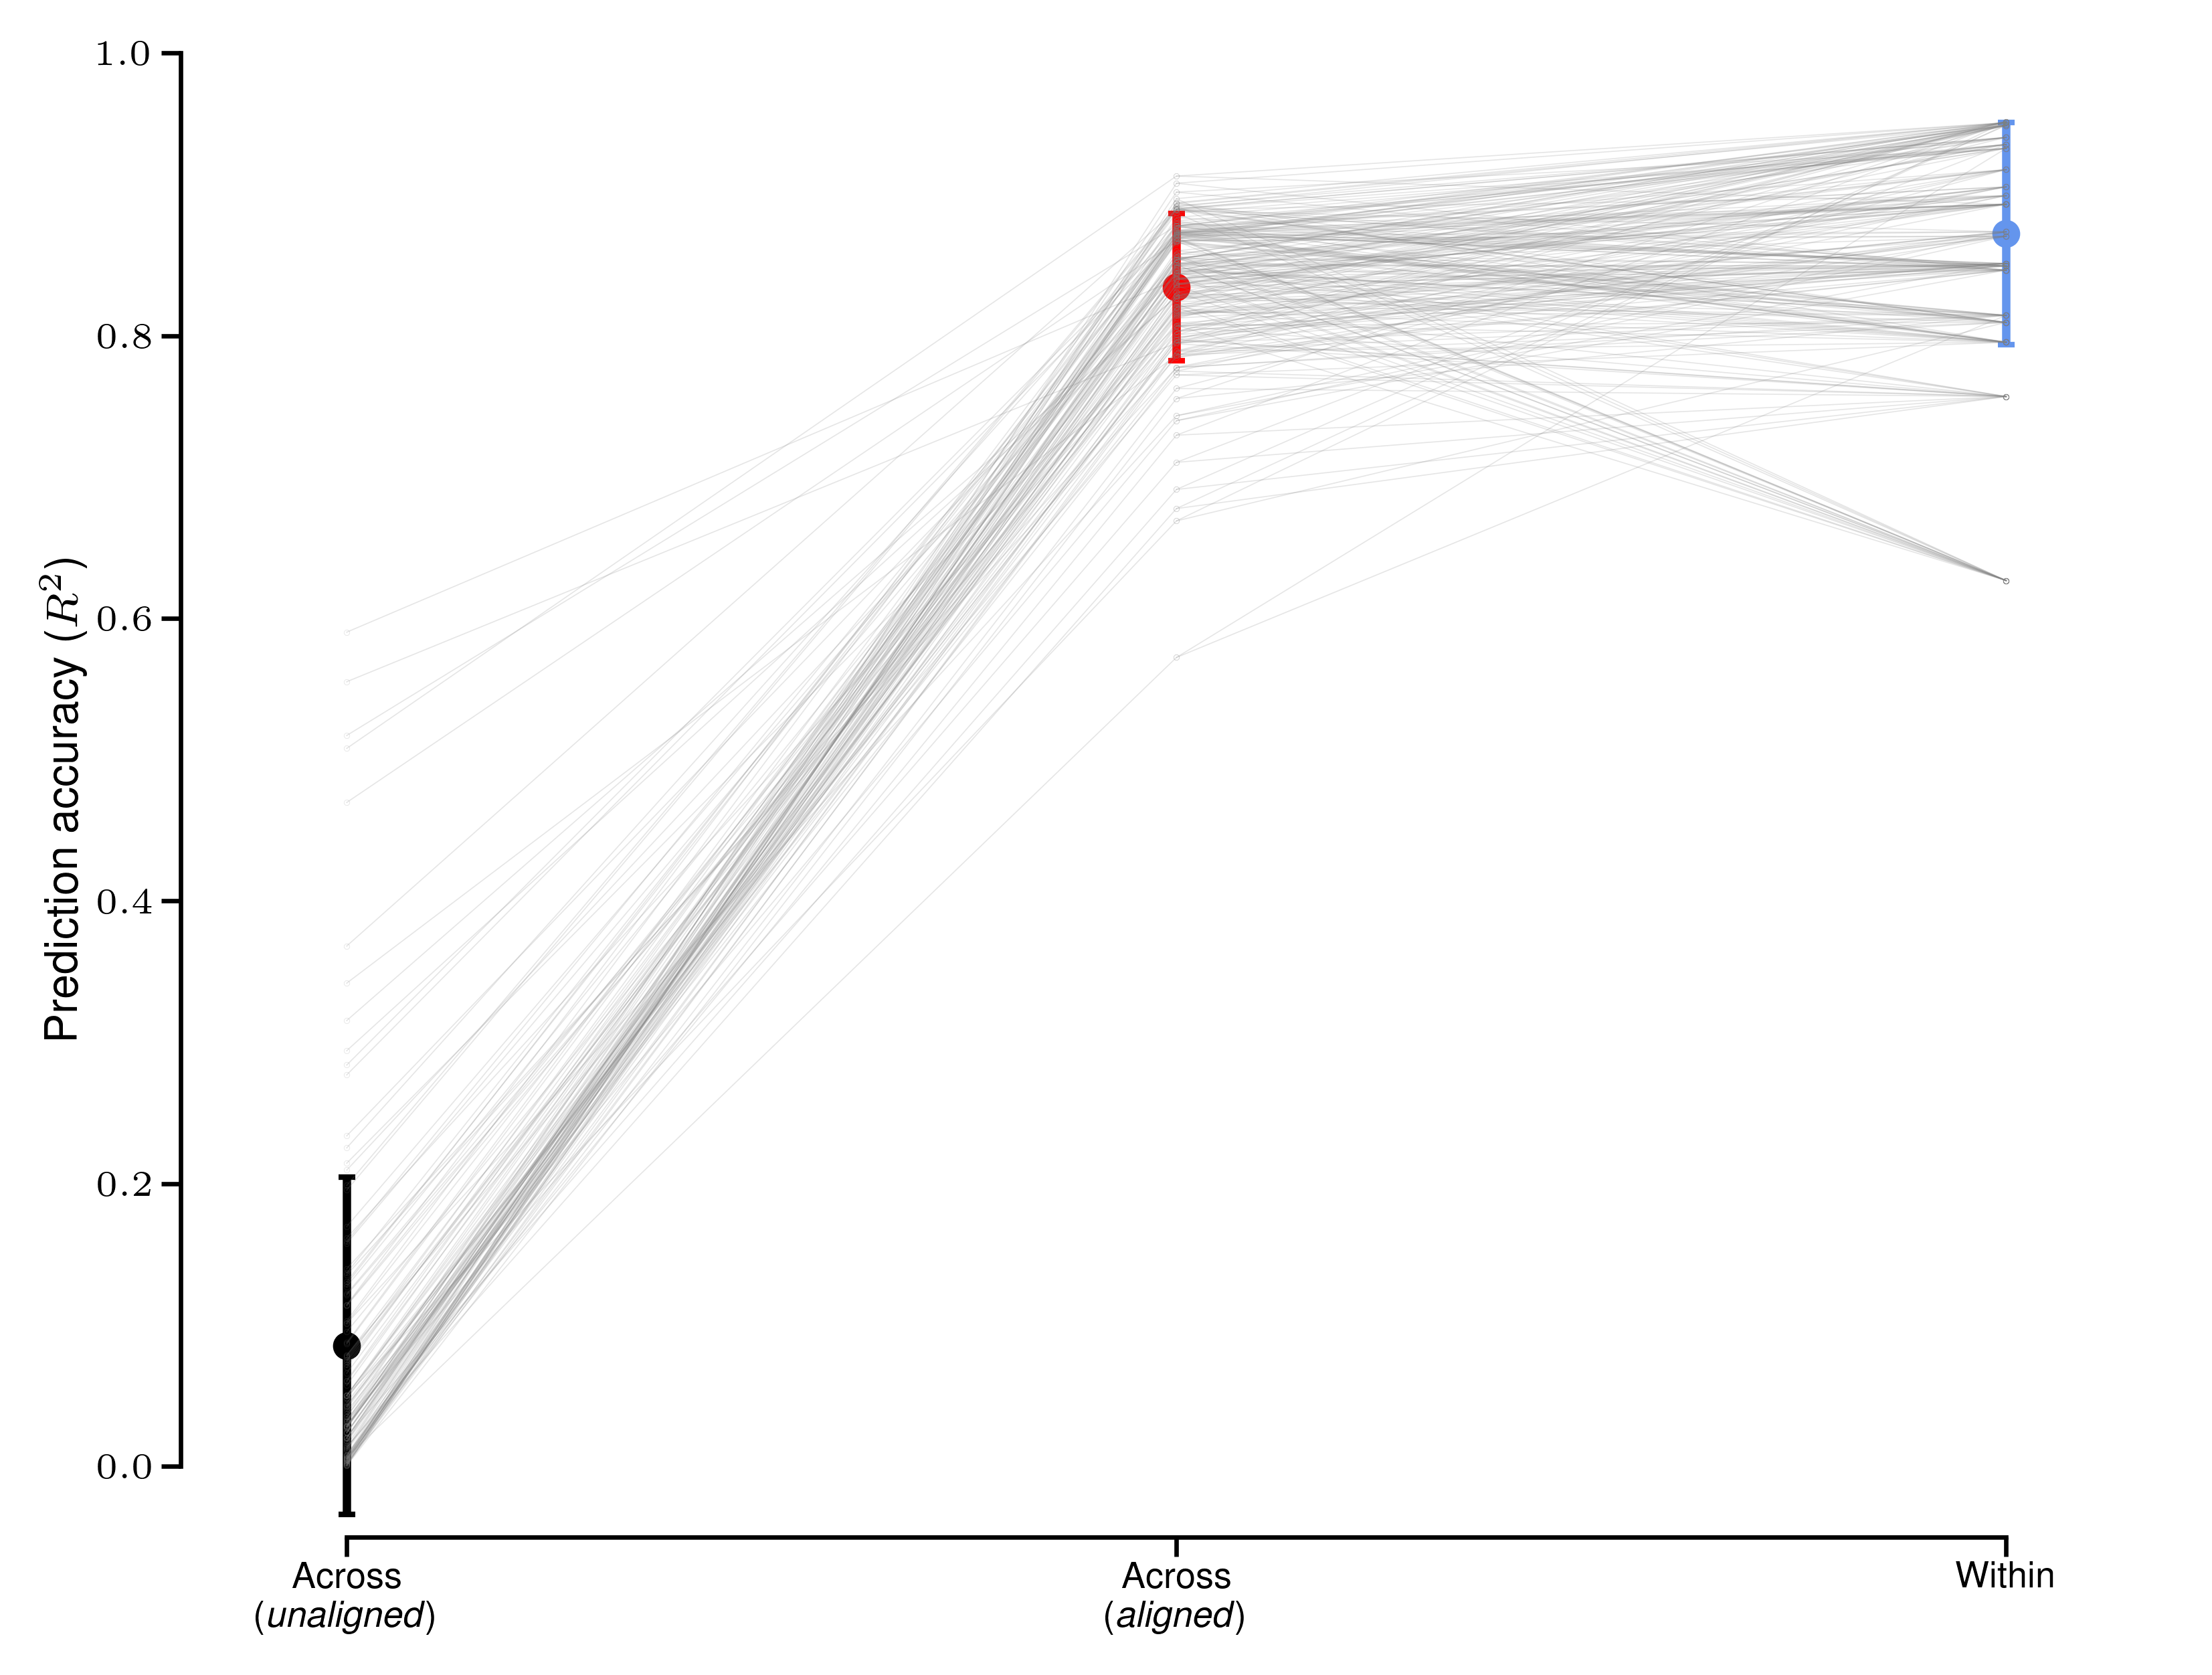

In [8]:
fig, ax = plt.subplots()
decode.plot_decoding(ax, allDFs_MCx_monkey, monkey_defs.exec_epoch, monkey_defs.areas[2], dataset='monkey')

fig.savefig(FIGPATH / 'monkey-decoding.pdf', format='pdf', bbox_inches='tight')

### Fig 2J: Mouse CCA plot

Across vs within: WilcoxonResult(statistic=0.0, pvalue=2.9802322387695312e-08)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=0.000244140625)
Executed: `plot_cca` in 8.4s


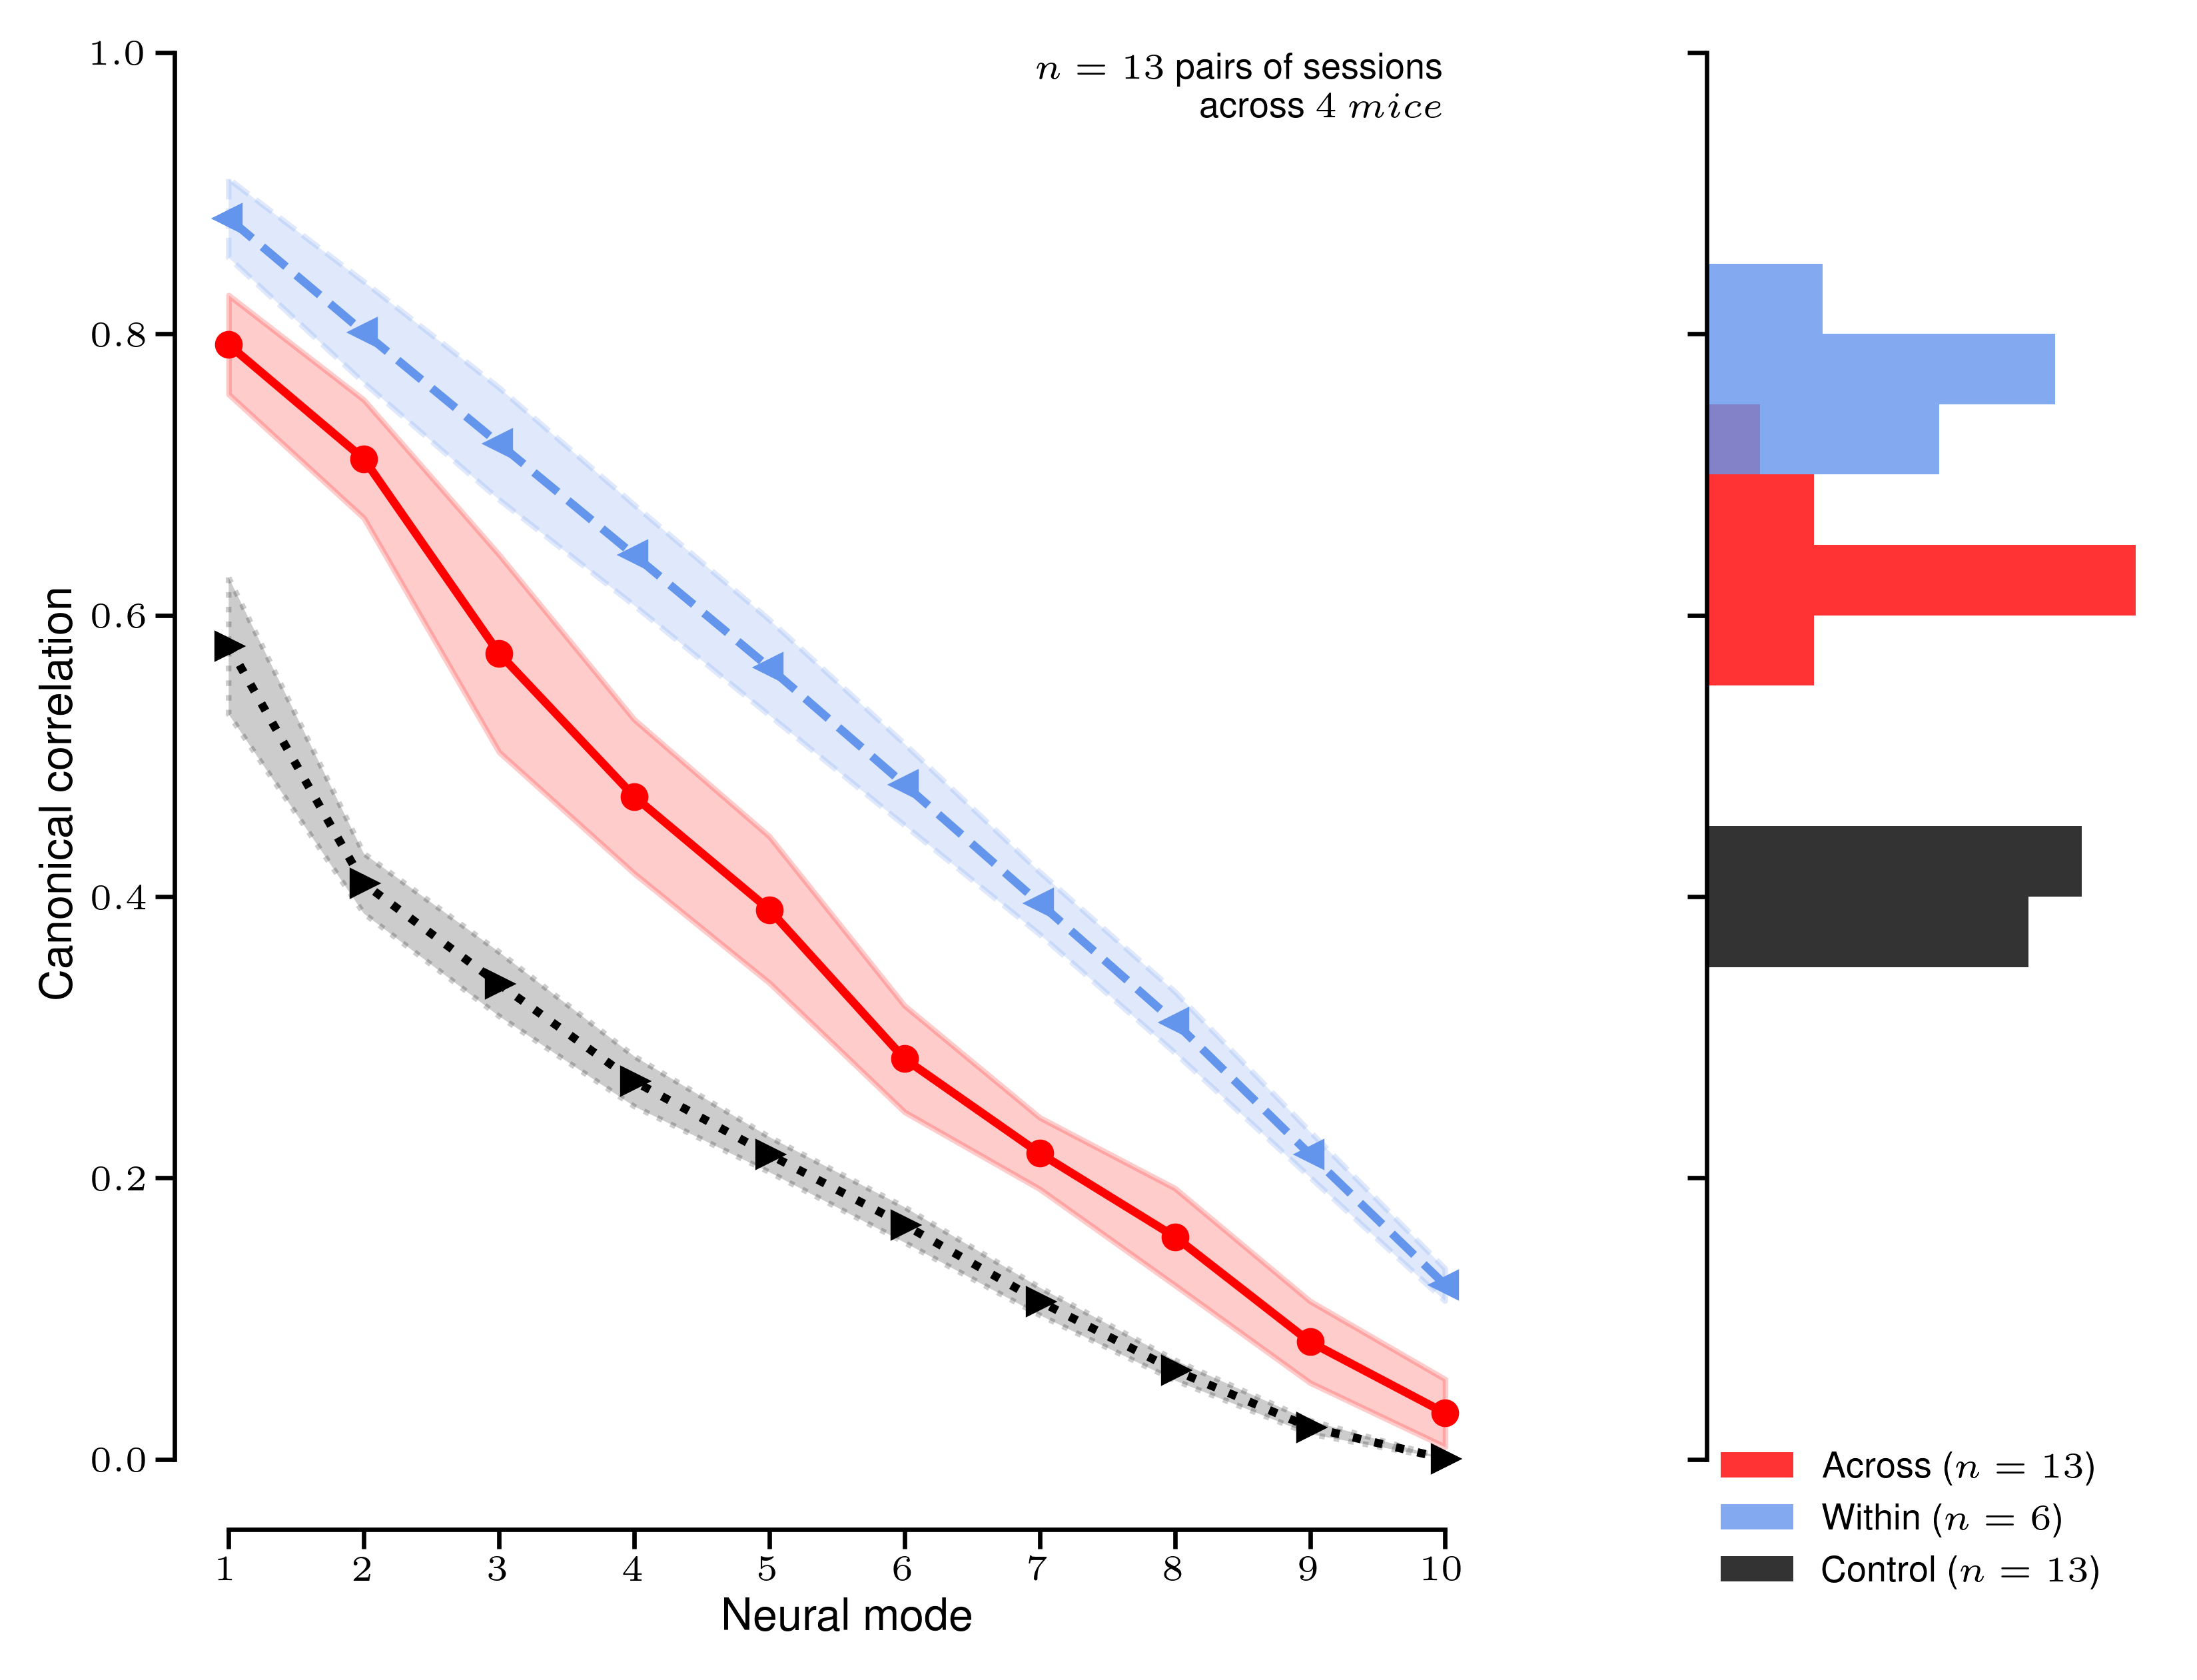

In [9]:
fig, axes = plt.subplots(ncols = 2, gridspec_kw={'width_ratios': [params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]]})

cca.plot_cca(axes[0], axes[1], allDFs_M1_mouse, 
            mouse_defs.exec_epoch, 
            mouse_defs.areas[0], 
            mouse_defs.n_components, 
            dataset='mouse')
fig.savefig(FIGPATH / 'mouse-cca.pdf', format='pdf', bbox_inches='tight')


### Fig 2K: behavioural correlation vs CCA

/home/jcc319/multi_animal_alignment/tools/corrTools.py:101: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1__, epoch_fun=monkey_defs.exec_epoch)
/home/jcc319/multi_animal_alignment/tools/corrTools.py:115: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interval(df2__, epoch_fun=monkey_defs.exec_epoch)
/home/jcc319/multi_animal_alignment/tools/corrTools.py:115: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df2 = pyal.restrict_to_interval(df2__, epoch_fun=monkey_defs.exec_epoch)
/home/jcc319/multi_animal_alignment/tools/corrTools.py:115: UserWarning: Dropping the trials with the following IDs because of invalid time

Executed: `plot_cca_corr` in 192.2s
Executed: `plot_cca_corr` in 21.6s


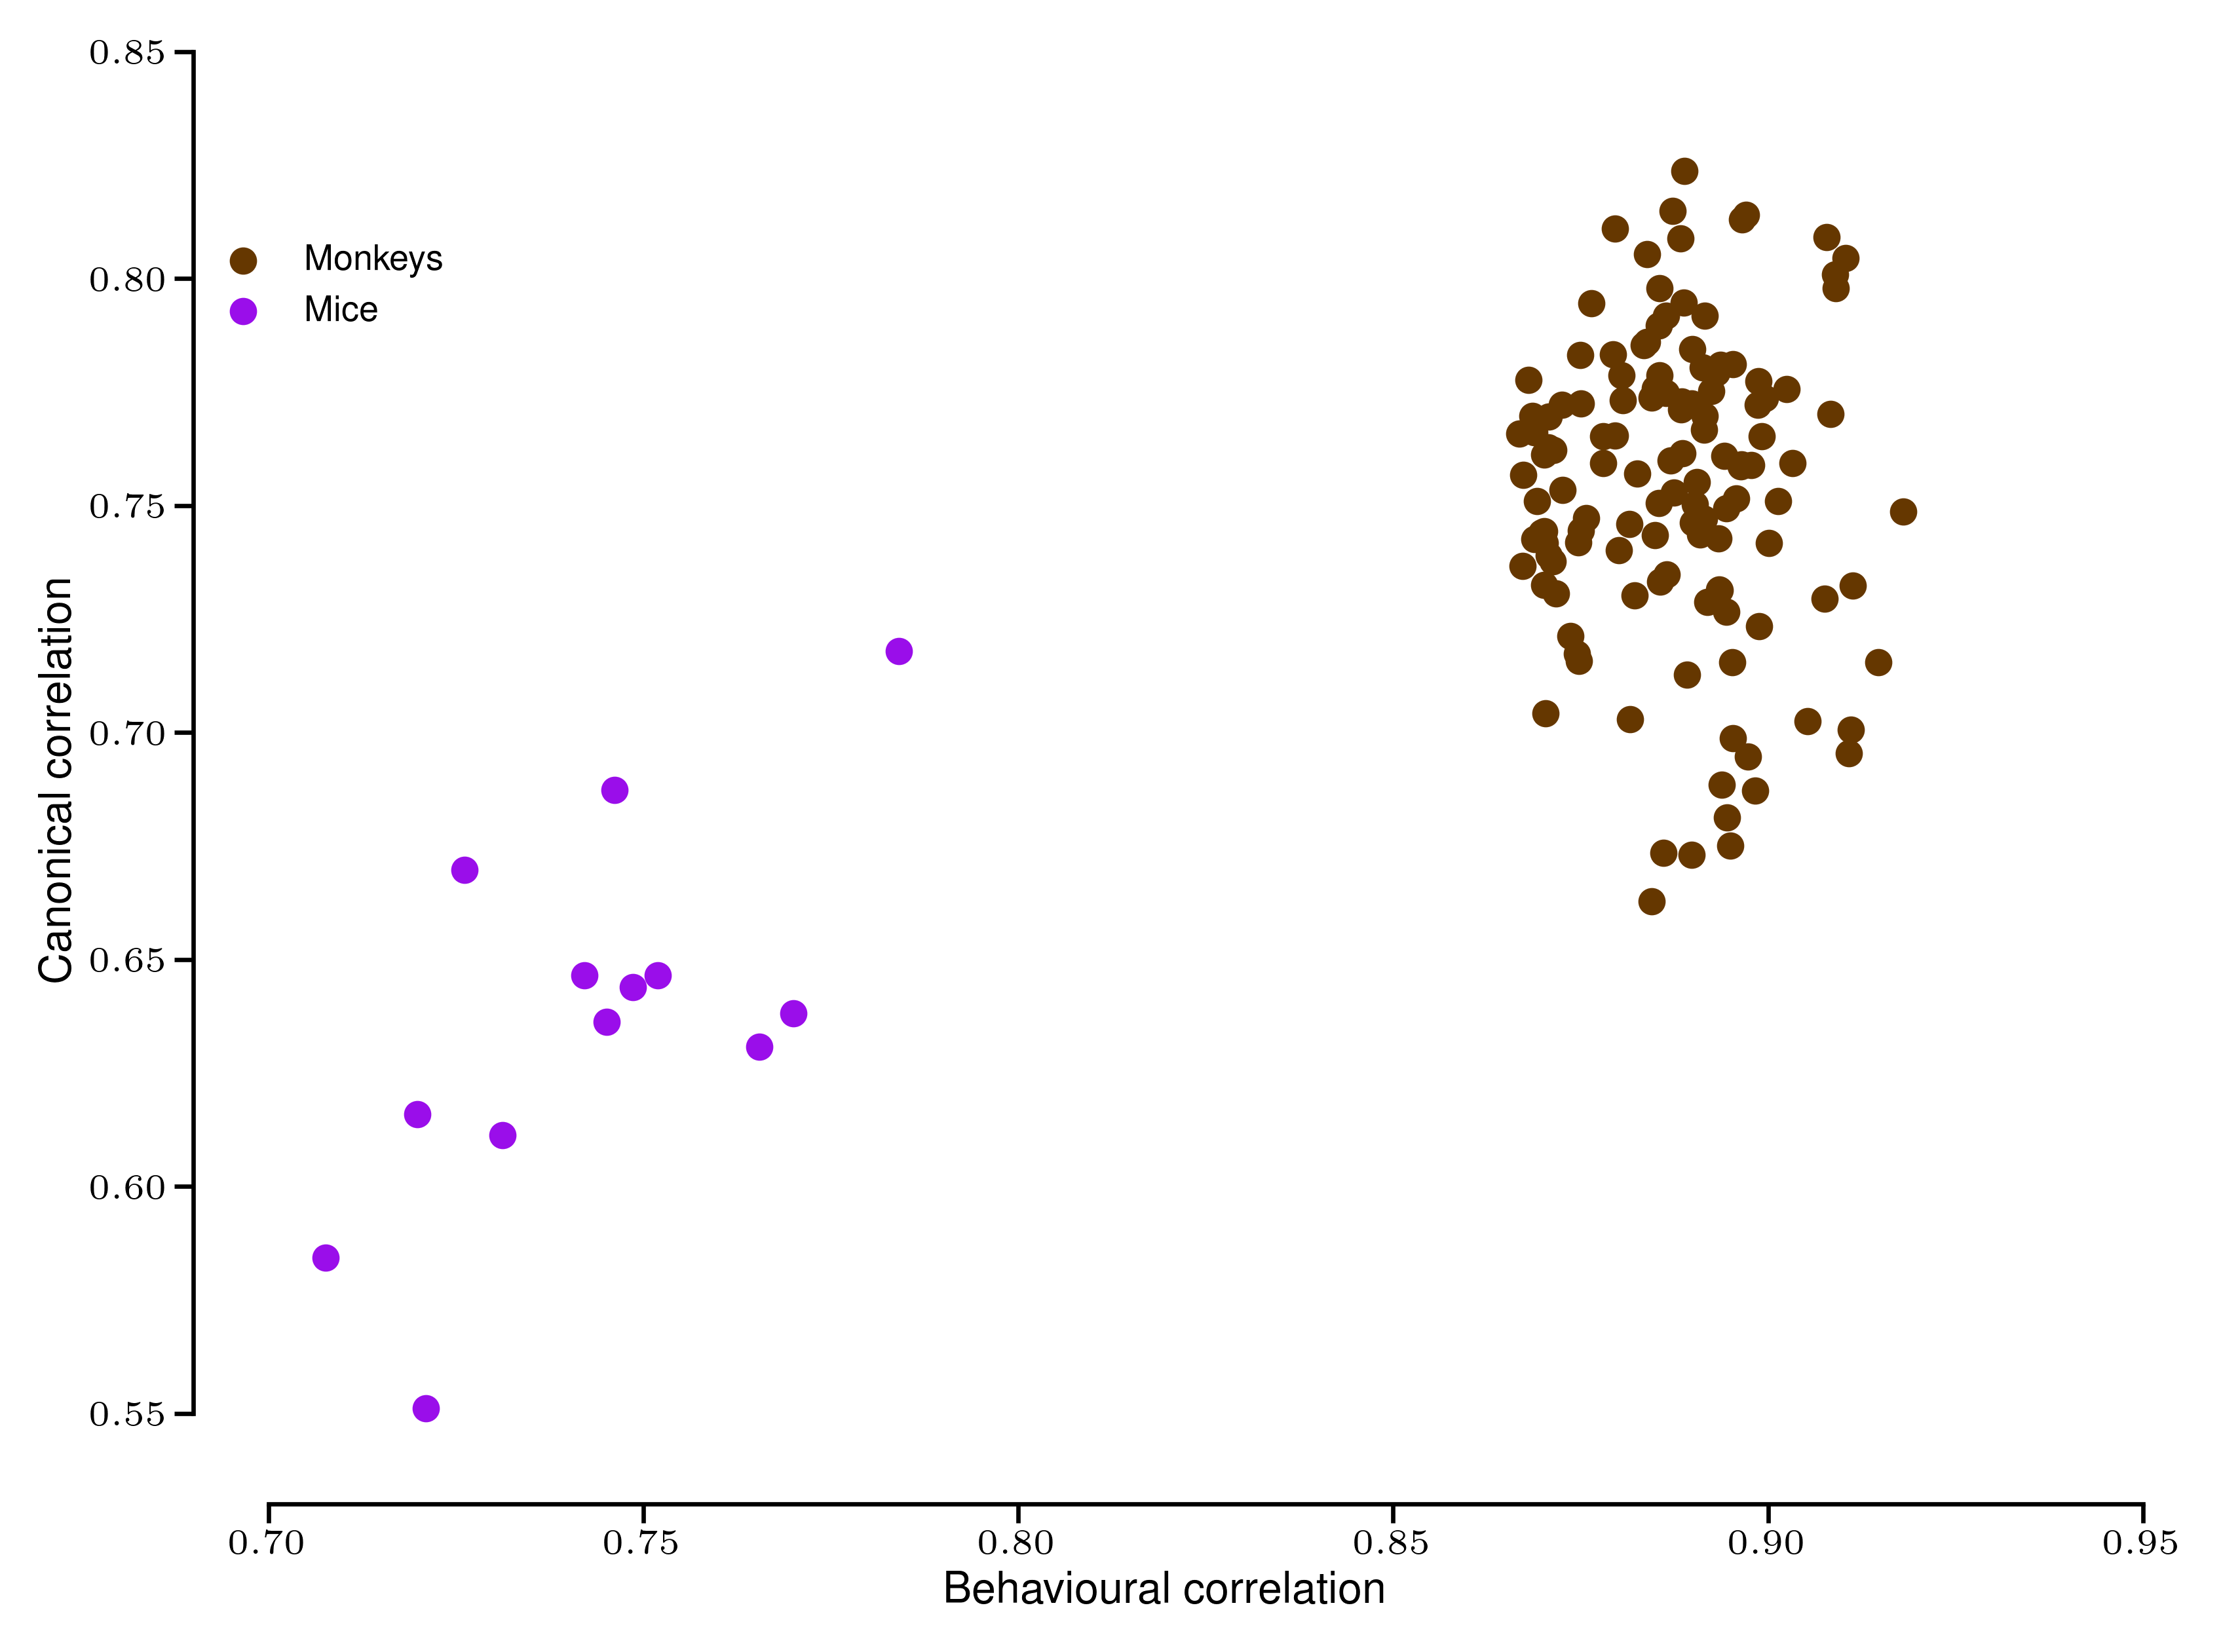

In [10]:
fig, ax = plt.subplots()
ct.plot_cca_corr(ax, allDFs_MCx_monkey, 
                 monkey_defs.exec_epoch, 
                 monkey_defs.areas[2], 
                 monkey_defs.n_components, 
                 dataset='monkey')
ct.plot_cca_corr(ax, allDFs_M1_mouse,
                 mouse_defs.exec_epoch, 
                 mouse_defs.areas[0], 
                 mouse_defs.n_components, 
                 dataset='mouse')

fig.savefig(FIGPATH / 'behav-corr-cca.pdf', format='pdf', bbox_inches='tight')


---

plot the within session trajectory correlations

In [11]:
@utility.report
def plot_traj_corr(ax, allDFs_MCx_monkey, allDFs_M1_mouse):

    within_corrs_monkeys = ct.trim_within_monkey_corr(allDFs_MCx_monkey)
    within_corrs_mice = ct.trim_within_mouse_corr(allDFs_M1_mouse)

    # plotting
    
    w_mice = list(within_corrs_mice.values())
    w_mice = np.array([l for L in w_mice for l in L])
    w_monkey = list(within_corrs_monkeys.values())
    w_monkey = np.array([l for L in w_monkey for l in L])
    ax.hist(w_mice,   density=True,alpha=.8,color=params.colors.MousePts, label=r'Mice')
    ax.hist(w_monkey, density=True,alpha=.8,color=params.colors.MonkeyPts, label=r'Monkeys')
    ax.axvline(w_mice.mean(), color=params.colors.MousePts, zorder=0)
    ax.axvline(w_monkey.mean(), color=params.colors.MonkeyPts, zorder=0)
    
    ax.set_yticks([])
    ax.set_xticks([0,1])
    ax.set_xlim([0,1])
    ax.tick_params(axis='x', direction='in')
    ax.set_ylabel('Probability\ndensity')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('None')

Executed: `plot_traj_corr` in 4.3s


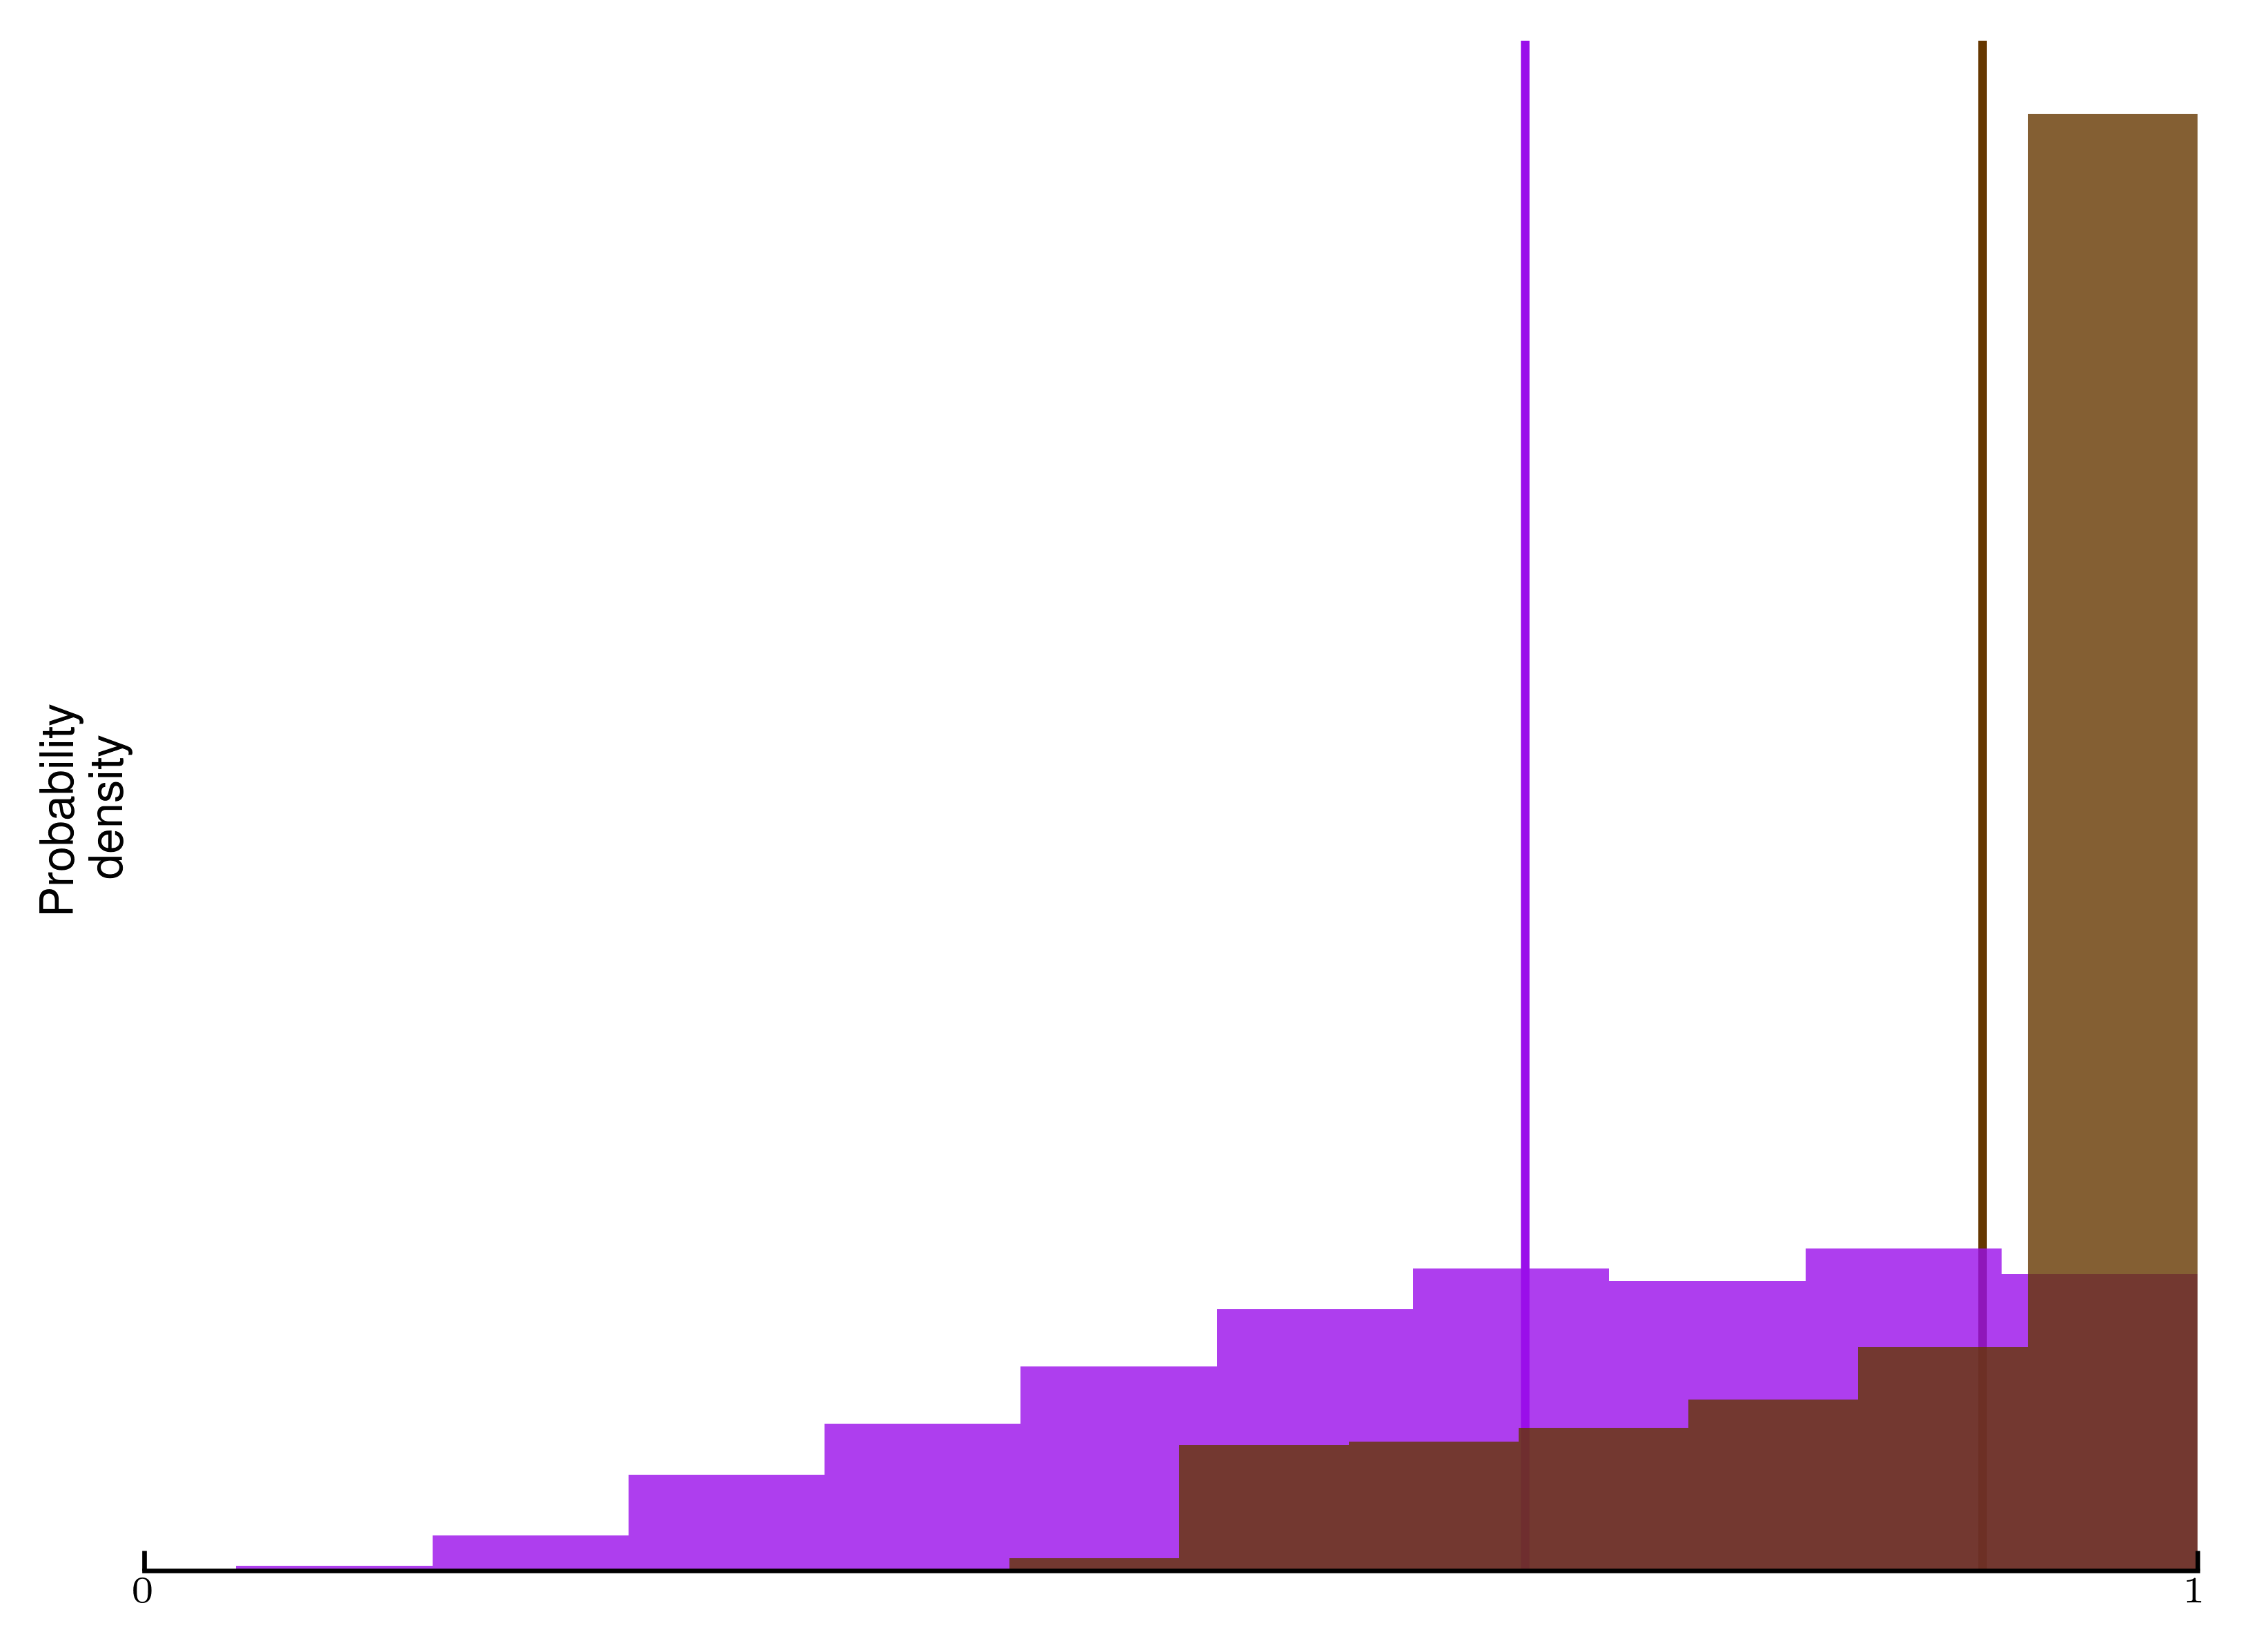

In [12]:
fig, ax = plt.subplots()
plot_traj_corr(ax, allDFs_MCx_monkey, allDFs_M1_mouse)
fig.savefig(FIGPATH / 'traj-corr.pdf', format='pdf', bbox_inches='tight')
